# Finetuning of BERT - Single Label (Veg)
This notebook is an adaptation of the `AFFECT-FINETUNING-BERTino_for_multi_label_text_classification.ipynb` notebook presented in class. 

The purpose is to finetune BERT (`bert-base-cased`) on our dataset, with the aim of doing binary classification over the label `Veg` (column `Vegetarian&Dessert` of the dataset obtained in the notebook Data_Understanding.ipynb).

In [15]:
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EvalPrediction

import torch
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from datasets import load_dataset, Features, Value, DatasetDict
from tqdm import tqdm

seed = 6
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

## Dataset Loading
We will use the cleaned and balanced dataset obtained in `Data_Understanding.ipynb`. Note that we have already kept the recipes with at most 512 tokens.

In [16]:
df = load_dataset('csv', data_files='dataset/dataset_balanced.csv')

Generating train split: 0 examples [00:00, ? examples/s]

In [17]:
# see datatype of df
print(type(df))

<class 'datasets.dataset_dict.DatasetDict'>


In [18]:
df.keys()

dict_keys(['train'])

In [19]:
df['train'].features

{'cooking_method': Value(dtype='string', id=None),
 'ingredients': Value(dtype='string', id=None),
 'tags': Value(dtype='string', id=None),
 'Vegetarian': Value(dtype='int64', id=None),
 'Dairy Free': Value(dtype='int64', id=None),
 'Gluten Free': Value(dtype='int64', id=None),
 'Low Carb': Value(dtype='int64', id=None),
 'Low Fat': Value(dtype='int64', id=None),
 'Low Sodium': Value(dtype='int64', id=None),
 'Dessert': Value(dtype='int64', id=None),
 'Meat': Value(dtype='int64', id=None),
 'Fish': Value(dtype='int64', id=None),
 'Dairy': Value(dtype='int64', id=None),
 'Vegetarian&Dessert': Value(dtype='int64', id=None),
 'Meat&Fish': Value(dtype='int64', id=None)}

## Data Casting
As we can see a few cells above, the first 3 features are already in the wanted data type: `string`. Let's cast the others into `bool` (... and make other adjustments). 

In [20]:
# REMOVE columns Vegetarian, Desert, Dairy, Meat, Fish, Meat&Fish since we will consider Vegetarian&Dessert
df = df.remove_columns(['Vegetarian', 'Dessert', 'Dairy', 'Meat', 'Fish', 'Meat&Fish'])

df['train'].features

{'cooking_method': Value(dtype='string', id=None),
 'ingredients': Value(dtype='string', id=None),
 'tags': Value(dtype='string', id=None),
 'Dairy Free': Value(dtype='int64', id=None),
 'Gluten Free': Value(dtype='int64', id=None),
 'Low Carb': Value(dtype='int64', id=None),
 'Low Fat': Value(dtype='int64', id=None),
 'Low Sodium': Value(dtype='int64', id=None),
 'Vegetarian&Dessert': Value(dtype='int64', id=None)}

In [21]:
# RENAME columns Vegetarian&Dessert to Veg

def rename_column(example):
    # Rename 'Vegetarian&Dessert' to 'Veg'
    if 'Vegetarian&Dessert' in example:
        example['Veg'] = example.pop('Vegetarian&Dessert')
    return example

# Apply the rename_column function to each example in the dataset
for split in df.keys():
    df[split] = df[split].map(rename_column)

df['train'].features

Map:   0%|          | 0/50902 [00:00<?, ? examples/s]

{'cooking_method': Value(dtype='string', id=None),
 'ingredients': Value(dtype='string', id=None),
 'tags': Value(dtype='string', id=None),
 'Dairy Free': Value(dtype='int64', id=None),
 'Gluten Free': Value(dtype='int64', id=None),
 'Low Carb': Value(dtype='int64', id=None),
 'Low Fat': Value(dtype='int64', id=None),
 'Low Sodium': Value(dtype='int64', id=None),
 'Veg': Value(dtype='int64', id=None)}

In [22]:
# CAST variables to boolean
df['train'] = df['train'].cast(Features({
    'cooking_method' : Value('string'),
    'ingredients' : Value('string'),
    'tags' : Value('string'),
    'Dairy Free': Value('bool'),
    'Gluten Free': Value('bool'),
    'Low Carb': Value('bool'),
    'Low Fat': Value('bool'),
    'Low Sodium': Value('bool'),
    'Veg': Value('bool')
}))

df['train'].features

Casting the dataset:   0%|          | 0/50902 [00:00<?, ? examples/s]

{'cooking_method': Value(dtype='string', id=None),
 'ingredients': Value(dtype='string', id=None),
 'tags': Value(dtype='string', id=None),
 'Dairy Free': Value(dtype='bool', id=None),
 'Gluten Free': Value(dtype='bool', id=None),
 'Low Carb': Value(dtype='bool', id=None),
 'Low Fat': Value(dtype='bool', id=None),
 'Low Sodium': Value(dtype='bool', id=None),
 'Veg': Value(dtype='bool', id=None)}

In [27]:
print('Percentage of Veg recipes is:', sum(df['train']['Veg'])/len(df['train'])*100, '%')

Percentage of Veg recipes is: 50.0 %


In [25]:
len(df['train'])

50902

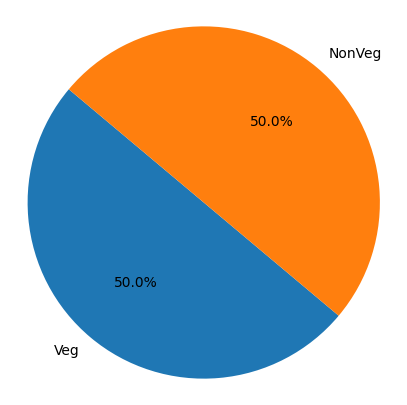

In [26]:
# Count the number of 'Veg' and 'NonVeg' recipes
veg_count = sum(df['train']['Veg'])
non_veg_count = len(df['train']) - veg_count

# Create a pie chart
plt.figure(figsize=(5,5))
plt.pie([veg_count, non_veg_count], labels=['Veg', 'NonVeg'], autopct='%1.1f%%', startangle=140)
plt.axis('equal')

# Display the pie chart
plt.show()

## Split
Let's split our dataset stratifying on `Veg`. We keep the 30% of the datasrt for Test, and the remaining 70% is splittet as 80/20 for the Train and Validation.

In [28]:
# column we want to stratify with respect to
stratify_column_name = "Veg"

# create class label column and stratify
df['train'] = df['train'].class_encode_column(stratify_column_name)

Stringifying the column:   0%|          | 0/50902 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/50902 [00:00<?, ? examples/s]

In [29]:
# Notice that now Veg has 'False' and 'True' as class labels
df['train'].features

{'cooking_method': Value(dtype='string', id=None),
 'ingredients': Value(dtype='string', id=None),
 'tags': Value(dtype='string', id=None),
 'Dairy Free': Value(dtype='bool', id=None),
 'Gluten Free': Value(dtype='bool', id=None),
 'Low Carb': Value(dtype='bool', id=None),
 'Low Fat': Value(dtype='bool', id=None),
 'Low Sodium': Value(dtype='bool', id=None),
 'Veg': ClassLabel(names=['False', 'True'], id=None)}

In [30]:
# split the dataset into train, validation and test stratifying with respect to Veg
df = df['train'].train_test_split(test_size=0.3, seed = seed, stratify_by_column = 'Veg')
train_validation = df['train'].train_test_split(test_size=0.2, seed = seed, stratify_by_column='Veg')

dataset = DatasetDict()
dataset['test'] = df['test']
dataset['train'] = train_validation['train']
dataset['validation'] = train_validation['test']
dataset.shape

{'test': (15271, 9), 'train': (28504, 9), 'validation': (7127, 9)}

In [31]:
# CAST 'Veg' back to boolean for split in dataset.keys()
dataset = dataset.cast(Features({
    'cooking_method' : Value('string'),
    'ingredients' : Value('string'),
    'tags' : Value('string'),
    'Dairy Free': Value('bool'),
    'Gluten Free': Value('bool'),
    'Low Carb': Value('bool'),
    'Low Fat': Value('bool'),
    'Low Sodium': Value('bool'),
    'Veg': Value('bool')
}))

Casting the dataset:   0%|          | 0/15271 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/28504 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/7127 [00:00<?, ? examples/s]

Now, let's create a list that contains the labels, as well as 2 dictionaries that map labels to integers and back.

In [32]:
dataset['train'].features.keys()

dict_keys(['cooking_method', 'ingredients', 'tags', 'Dairy Free', 'Gluten Free', 'Low Carb', 'Low Fat', 'Low Sodium', 'Veg'])

In [33]:
labels = [label for label in dataset['train'].features.keys() if label not in ['cooking_method','ingredients', 'tags', 'Dairy Free', 'Gluten Free', 'Low Carb', 'Low Fat', 'Low Sodium']]
labels

['Veg']

In [34]:
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}

id2label, label2id

({0: 'Veg'}, {'Veg': 0})

## Data Preprocessing

In [35]:
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-cased")

c:\Users\chucki\Desktop\projects\HLT-Project\.venv\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [36]:
def preprocess_data(examples):
  # take a batch of texts
  text = examples["cooking_method"]
  # encode them
  encoding = tokenizer(text, padding="max_length", truncation=True, max_length=512)
  # add labels
  labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
  # create numpy array of shape (batch_size, num_labels)
  labels_matrix = np.zeros((len(text), len(labels)))
  # fill numpy array
  for idx, label in enumerate(labels):
    labels_matrix[:, idx] = labels_batch[label]

  encoding["labels"] = labels_matrix.tolist()
  
  return encoding

In [37]:
encoded_dataset = dataset.map(preprocess_data, batched=True, remove_columns=dataset['train'].column_names)

Map:   0%|          | 0/15271 [00:00<?, ? examples/s]

Map:   0%|          | 0/28504 [00:00<?, ? examples/s]

Map:   0%|          | 0/7127 [00:00<?, ? examples/s]

In [38]:
encoded_dataset['train'].features

{'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'labels': Sequence(feature=Value(dtype='float64', id=None), length=-1, id=None)}

Let's experiment with a recipe to understand the functioning of each step.

In [39]:
i = encoded_dataset['train'][0]['input_ids']
len(i)

512

In [40]:
# let's see how many pads are added
pads = [token for token in i if token == 0]
len(pads)

361

In [41]:
# notice that the last tokens are [PAD] tokens!
tokenizer.decode(i)

"[CLS] ['Heat a large nonstick skillet over medium heat. On one half of a tortilla, layer some provolone, then a layer of beef, then some roasted peppers. Fold in half to cover the lling. Repeat to make 3 more quesadillas. 2. Add 1 tablespoon olive oil to the skillet. Add 2 quesadillas and cook until golden on the outside and gooey in the middle, 4 to 6 minutes per side. Slide out of the pan and sprinkle lightly with garlic salt. Repeat with the remaining 2 quesadillas. Cut into wedges and serve with giardiniera relish.'] [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

In [42]:
encoded_dataset['train'][0]['labels']

[0.0]

In [43]:
# This recipe is not Veg therefore we get []
[id2label[idx] for idx, label in enumerate(encoded_dataset['train'][0]['labels']) if label == 1.0]

[]

Now, let's make Train/Val/Test PyTorch datasets.

In [44]:
encoded_dataset.set_format("torch")

In [45]:
type(encoded_dataset)

datasets.dataset_dict.DatasetDict

In [39]:
model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-cased", 
                                                           num_labels=len(labels),
                                                           id2label=id2label,
                                                           label2id=label2id
                                                           )

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Train the model!
We tried different configurations of the hyperparameters; the best one is reported below.

In [ ]:
args = TrainingArguments(
    f"google-bert/bert-base-cased",
    evaluation_strategy = "steps",
    save_strategy = "steps",
    save_steps = 250,
    eval_steps = 250,
    save_total_limit = 2,
    learning_rate = 1e-4,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    num_train_epochs = 5,
    weight_decay = 0.05,
    warmup_steps = 2,
    load_best_model_at_end = True,
    metric_for_best_model = 'f1',
    #push_to_hub = True
)

In [ ]:
def single_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average='micro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = single_label_metrics(
        predictions=preds, 
        labels=p.label_ids)
    return result

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

# Evaluation

In [ ]:
trainer.evaluate()

In [ ]:
trainer.save_model("./models/bert-finetuned-veg-group15")

---
# Testing the finetuned model

In [46]:
# NOTE: run this cell if you don't have the finetuned model in memory and change the path to the location of the model
path = './models/bert-finetuned-veg-group15'
model = AutoModelForSequenceClassification.from_pretrained(path)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [47]:
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, recall_score, precision_score, classification_report


def single_label_metrics_test(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average='micro')
    accuracy = accuracy_score(y_true, y_pred)
    recall_micro = recall_score(y_true, y_pred, average='micro')
    precision_micro = precision_score(y_true, y_pred, average='micro')

    f1_macro_average = f1_score(y_true=y_true, y_pred=y_pred, average='macro')
    recall_macro = recall_score(y_true, y_pred, average='macro')
    precision_macro = precision_score(y_true, y_pred, average='macro')

    f1_weighted_average = f1_score(y_true=y_true, y_pred=y_pred, average='weighted')
    recall_weighted = recall_score(y_true, y_pred, average='weighted')
    precision_weighted = precision_score(y_true, y_pred, average='weighted')

    f1_binary = f1_score(y_true=y_true, y_pred=y_pred, average='binary')
    recall_binary = recall_score(y_true, y_pred, average='binary')
    precision_binary = precision_score(y_true, y_pred, average='binary')
    
    print(labels)

    # do a classification report
    class_report = classification_report(y_true, y_pred, target_names=['NonVeg', 'Veg'])
    print(class_report)
    


    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy,
               'recall': recall_micro,
               'precision': precision_micro,
               'f1_macro': f1_macro_average,
               'recall_macro': recall_macro,
               'precision_macro': precision_macro,
               'f1_weighted': f1_weighted_average,
               'recall_weighted': recall_weighted,
               'precision_weighted': precision_weighted,
                'f1_binary': f1_binary,
                'recall_binary': recall_binary,
                'precision_binary': precision_binary,
                'y_true': y_true,
                'y_pred': y_pred
               }
    
    return metrics, y_true, y_pred

def compute_metrics_test(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result, y_true, y_pred = single_label_metrics_test(
        predictions=preds, 
        labels=p.label_ids)
    
    cm = confusion_matrix(y_true, y_pred)
    # print the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

    return result

In [48]:
dataset['test']
print("Keys in dataset:", dataset.keys())

# Check the length of the test dataset
print("Length of test dataset:", len(dataset['test']))

print(len(dataset['test']))

Keys in dataset: dict_keys(['test', 'train', 'validation'])
Length of test dataset: 15271
15271


  0%|          | 0/1909 [00:00<?, ?it/s]

[[0.]
 [0.]
 [1.]
 ...
 [0.]
 [1.]
 [0.]]
              precision    recall  f1-score   support

      NonVeg       0.98      0.97      0.97      7635
         Veg       0.97      0.98      0.97      7636

    accuracy                           0.97     15271
   macro avg       0.97      0.97      0.97     15271
weighted avg       0.97      0.97      0.97     15271



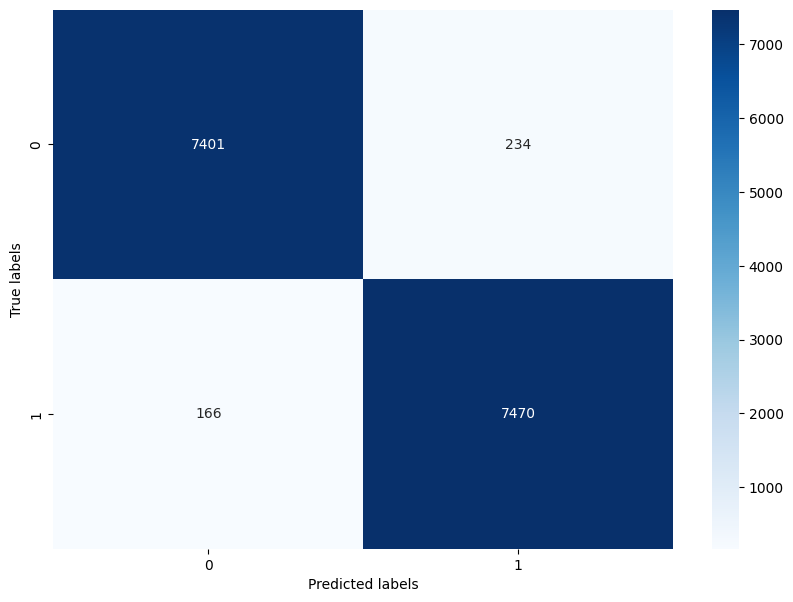

Trainer is attempting to log a value of "[[0.]
 [0.]
 [1.]
 ...
 [0.]
 [1.]
 [0.]]" of type <class 'numpy.ndarray'> for key "eval/y_true" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[[0.]
 [0.]
 [1.]
 ...
 [0.]
 [1.]
 [0.]]" of type <class 'numpy.ndarray'> for key "eval/y_pred" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


In [49]:
trainer = Trainer(
    model=model,
    compute_metrics=compute_metrics_test
)

# Evaluate on the test set
results = trainer.evaluate(eval_dataset=encoded_dataset['test'])

#print(results)

|             | Precision | Recall | F1-Score | Support |
|-------------|-----------|--------|----------|---------|
| NonVeg      | 0.98      | 0.97   | 0.97     | 7635    |
| Veg         | 0.97      | 0.98   | 0.97     | 7636    |
|             |           |        |          |         |
| Accuracy    |           |        | 0.97     | 15271   |
| Macro Avg   | 0.97      | 0.97   | 0.97     | 15271   |
| Weighted Avg| 0.97      | 0.97   | 0.97     | 15271   |

C:\Users\chucki\AppData\Local\Temp\ipykernel_1988\2901484870.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette='viridis')


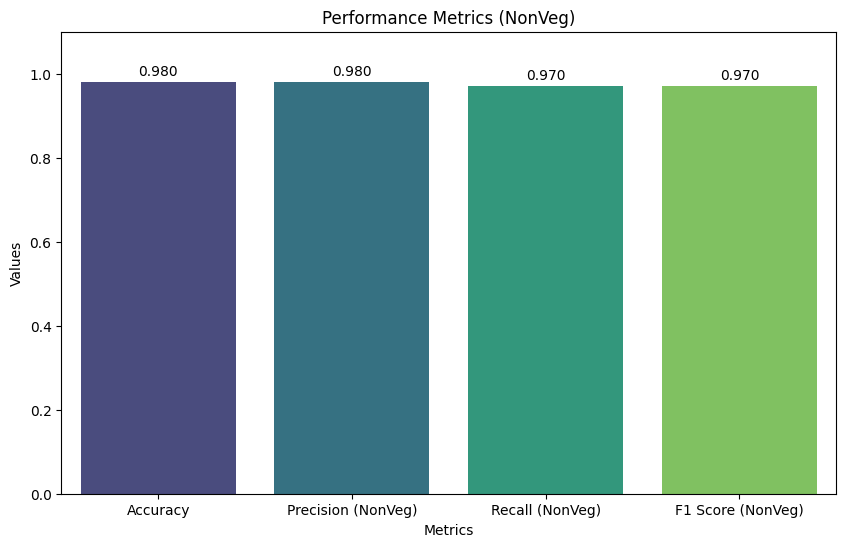

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics
accuracy = 0.98
precision = 0.98
recall = 0.97
f1_score = 0.97

# Plotting Accuracy, Precision, Recall, and F1 Score
metrics = ['Accuracy', 'Precision (NonVeg)', 'Recall (NonVeg)', 'F1 Score (NonVeg)']
values = [accuracy, precision, recall, f1_score]

plt.figure(figsize=(10, 6))
sns.barplot(x=metrics, y=values, palette='viridis')
plt.title('Performance Metrics (NonVeg)')
plt.ylim(0, 1.1)
for i in range(len(values)):
    plt.text(i, values[i]+0.01, f'{values[i]:.3f}', ha='center', va='bottom')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.show()
